# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "VAE"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'VAE',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                        
Sample_178  B1AMW1;H0YDI1;P19256;P19256-2;P19256-3   14.845
Sample_043  P01593;P01594                            18.321
Sample_075  Q9BU40-2;Q9BU40-4;Q9BU40-5               16.972
Sample_087  Q9NZ08;Q9NZ08-2                          15.777
Sample_187  Q8NFY4;Q8NFY4-6                          16.283
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by VAE: runs/alzheimer_study/preds/pred_real_na_VAE.csv


Sample ID   protein groups      
Sample_030  Q9BUN1                 16.853
Sample_115  A8MU39;H0YDU8;P53041   12.106
Sample_051  Q96GD0                 13.023
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 12.945
            A0A075B6Q5                 12.815
            A0A075B6R2                 11.424
            A0A075B6S5                 13.352
            A0A087WSY4                 13.165
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   13.184
            Q9UI40;Q9UI40-2            13.289
            Q9UIW2                     13.027
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   11.634
            Q9UP79                     12.046
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.241,15.050,16.842,19.863,15.950,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.775,19.067,...,15.528,15.576,14.351,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.880,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.572,17.705,17.039,15.881,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.320,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.493,15.345,17.084,18.708,14.249,19.433,11.561,11.226
Sample_207,15.739,16.877,15.469,16.898,14.750,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,14.460,14.036,13.488,12.148,15.006,13.123,12.119,13.380,13.779,12.401
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,13.515,19.067,16.127,...,11.475,11.278,12.336,12.668,12.777,12.595,12.426,12.900,13.054,12.334
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,13.456,13.628,11.652,11.405,12.717,12.626,12.906,12.313,13.743,13.158
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,12.511,13.364,12.559,12.200,12.691,12.231,13.363,12.986,13.850,12.328
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,13.667,11.744,12.378,13.432,13.293,12.166,12.768,12.402,11.942,13.033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.320,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 367.21it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 11.01it/s]

100%|██████████| 2/2 [00:00<00:00, 10.96it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  6.56it/s]

100%|██████████| 3/3 [00:00<00:00,  4.56it/s]

100%|██████████| 3/3 [00:00<00:00,  4.85it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.31it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.56it/s]

100%|██████████| 4/4 [00:00<00:00,  6.36it/s]

100%|██████████| 4/4 [00:00<00:00,  6.71it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00, 11.88it/s]

 80%|████████  | 4/5 [00:00<00:00,  7.31it/s]

100%|██████████| 5/5 [00:00<00:00,  6.71it/s]

100%|██████████| 5/5 [00:00<00:00,  7.20it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  8.16it/s]

 50%|█████     | 3/6 [00:00<00:00,  5.59it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.66it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  4.41it/s]

100%|██████████| 6/6 [00:01<00:00,  4.37it/s]

100%|██████████| 6/6 [00:01<00:00,  4.76it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00, 11.12it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  5.52it/s]

 71%|███████▏  | 5/7 [00:00<00:00,  4.78it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.89it/s]

100%|██████████| 7/7 [00:01<00:00,  3.50it/s]

100%|██████████| 7/7 [00:01<00:00,  4.16it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00, 10.40it/s]

 50%|█████     | 4/8 [00:00<00:00,  6.85it/s]

 62%|██████▎   | 5/8 [00:00<00:00,  6.79it/s]

 75%|███████▌  | 6/8 [00:00<00:00,  6.13it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  5.31it/s]

100%|██████████| 8/8 [00:01<00:00,  4.61it/s]

100%|██████████| 8/8 [00:01<00:00,  5.56it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  6.59it/s]

 33%|███▎      | 3/9 [00:00<00:01,  5.02it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.86it/s]

 56%|█████▌    | 5/9 [00:00<00:00,  4.87it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  4.55it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  4.46it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  4.36it/s]

100%|██████████| 9/9 [00:01<00:00,  4.33it/s]

100%|██████████| 9/9 [00:01<00:00,  4.62it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  6.94it/s]

 30%|███       | 3/10 [00:00<00:01,  4.88it/s]

 40%|████      | 4/10 [00:00<00:01,  4.89it/s]

 50%|█████     | 5/10 [00:01<00:01,  4.62it/s]

 60%|██████    | 6/10 [00:01<00:00,  4.24it/s]

 70%|███████   | 7/10 [00:01<00:00,  4.36it/s]

 80%|████████  | 8/10 [00:01<00:00,  4.58it/s]

 90%|█████████ | 9/10 [00:01<00:00,  4.70it/s]

100%|██████████| 10/10 [00:02<00:00,  4.73it/s]

100%|██████████| 10/10 [00:02<00:00,  4.73it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.84it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.57it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.26it/s]

 45%|████▌     | 5/11 [00:01<00:01,  4.44it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  4.59it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  4.43it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  4.76it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.97it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.99it/s]

100%|██████████| 11/11 [00:02<00:00,  4.37it/s]

100%|██████████| 11/11 [00:02<00:00,  4.41it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:00, 12.84it/s]

 33%|███▎      | 4/12 [00:00<00:00,  8.31it/s]

 42%|████▏     | 5/12 [00:00<00:01,  5.95it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.71it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  4.30it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  4.19it/s]

 75%|███████▌  | 9/12 [00:01<00:00,  4.34it/s]

 83%|████████▎ | 10/12 [00:01<00:00,  4.83it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  4.94it/s]

100%|██████████| 12/12 [00:02<00:00,  5.00it/s]

100%|██████████| 12/12 [00:02<00:00,  5.13it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:00, 14.07it/s]

 31%|███       | 4/13 [00:00<00:01,  8.53it/s]

 38%|███▊      | 5/13 [00:00<00:01,  7.79it/s]

 46%|████▌     | 6/13 [00:00<00:00,  7.70it/s]

 54%|█████▍    | 7/13 [00:00<00:00,  7.43it/s]

 62%|██████▏   | 8/13 [00:01<00:00,  7.30it/s]

 69%|██████▉   | 9/13 [00:01<00:00,  7.22it/s]

 77%|███████▋  | 10/13 [00:01<00:00,  6.71it/s]

 85%|████████▍ | 11/13 [00:01<00:00,  6.49it/s]

 92%|█████████▏| 12/13 [00:01<00:00,  5.67it/s]

100%|██████████| 13/13 [00:01<00:00,  6.00it/s]

100%|██████████| 13/13 [00:01<00:00,  6.94it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:00, 14.11it/s]

 29%|██▊       | 4/14 [00:00<00:01,  8.21it/s]

 36%|███▌      | 5/14 [00:00<00:01,  7.89it/s]

 43%|████▎     | 6/14 [00:00<00:01,  7.81it/s]

 50%|█████     | 7/14 [00:00<00:00,  7.56it/s]

 57%|█████▋    | 8/14 [00:01<00:00,  6.54it/s]

 64%|██████▍   | 9/14 [00:01<00:00,  6.14it/s]

 71%|███████▏  | 10/14 [00:01<00:00,  6.37it/s]

 79%|███████▊  | 11/14 [00:01<00:00,  6.50it/s]

 86%|████████▌ | 12/14 [00:01<00:00,  6.47it/s]

 93%|█████████▎| 13/14 [00:01<00:00,  6.58it/s]

100%|██████████| 14/14 [00:01<00:00,  6.68it/s]

100%|██████████| 14/14 [00:01<00:00,  7.03it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:00, 13.92it/s]

 27%|██▋       | 4/15 [00:00<00:01,  8.88it/s]

 33%|███▎      | 5/15 [00:00<00:01,  6.75it/s]

 40%|████      | 6/15 [00:00<00:01,  6.61it/s]

 47%|████▋     | 7/15 [00:00<00:01,  6.73it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  6.92it/s]

 60%|██████    | 9/15 [00:01<00:00,  6.91it/s]

 67%|██████▋   | 10/15 [00:01<00:00,  7.07it/s]

 73%|███████▎  | 11/15 [00:01<00:00,  7.07it/s]

 80%|████████  | 12/15 [00:01<00:00,  7.03it/s]

 87%|████████▋ | 13/15 [00:01<00:00,  7.06it/s]

 93%|█████████▎| 14/15 [00:01<00:00,  7.02it/s]

100%|██████████| 15/15 [00:02<00:00,  7.07it/s]

100%|██████████| 15/15 [00:02<00:00,  7.20it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.004      0.040 0.018          0.876 0.208       0.163   
2             0.002 0.000      0.020 0.000          0.784 0.079       0.728   
3             0.003 0.001      0.037 0.011          0.789 0.097       0.741   
4             0.005 0.004      0.044 0.019          0.815 0.090       0.801   
5             0.002 0.000      0.020 0.001          0.816 0.086       0.803   
6             0.003 0.001      0.029 0.015          0.840 0.079       0.849   
7             0.004 0.002      0.037 0.011          0.841 0.081       0.853   
8             0.006 0.005      0.052 0.019          0.836 0.081       0.838   
9             0.004 0.003      0.044 0.017          0.832 0.081       0.847   
10            0.003 0.001      0.032 0.008          0.829 0.083       0.839   
11            0.004 0.002      0.035 0.011          0.833 0.082       0.840   
12            0.003 0.001      0.030 0.011          0.832 0.080       0.826   
13            0.002 0.000      0.022 0.011          0.829 0.076       0.822   
14            0.002 0.001      0.022 0.005          0.829 0.080       0.822   
15            0.002 0.001      0.022 0.005          0.826 0.084       0.820   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.090   0.266 0.125                  0.573 0.043        0.861   
2          0.102   0.750 0.072                  0.789 0.057        0.866   
3          0.113   0.758 0.080                  0.795 0.064        0.891   
4          0.113   0.802 0.075                  0.832 0.062        0.893   
5          0.106   0.804 0.070                  0.833 0.059        0.896   
6          0.090   0.841 0.063                  0.864 0.053        0.920   
7          0.092   0.843 0.064                  0.866 0.055        0.919   
8          0.095   0.833 0.065                  0.857 0.056        0.918   
9          0.088   0.836 0.063                  0.859 0.055        0.918   
10         0.094   0.831 0.068                  0.855 0.059        0.917   
11         0.093   0.833 0.066                  0.857 0.057        0.916   
12         0.092   0.825 0.063                  0.850 0.053        0.914   
13         0.093   0.822 0.063                  0.848 0.054        0.913   
14         0.091   0.821 0.064                  0.847 0.055        0.912   
15         0.090   0.819 0.064                  0.845 0.054        0.914   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.059                  0.828 0.086        210.000 0.000  
2          0.058                  0.825 0.074        210.000 0.000  
3          0.055                  0.860 0.079        210.000 0.000  
4          0.054                  0.868 0.068        210.000 0.000  
5          0.051                  0.870 0.063        210.000 0.000  
6          0.047                  0.908 0.051        210.000 0.000  
7          0.049                  0.908 0.052        210.000 0.000  
8          0.049                  0.909 0.050        210.000 0.000  
9          0.050                  0.909 0.052        210.000 0.000  
10         0.051                  0.908 0.052        210.000 0.000  
11         0.051                  0.907 0.053        210.000 0.000  
12         0.052                  0.905 0.052        210.000 0.000  
13         0.051                  0.904 0.052        210.000 0.000  
14         0.052                  0.903 0.053        210.000 0.000  
15         0.051                  0.907 0.050 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 446.16it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 10.11it/s]

100%|██████████| 2/2 [00:00<00:00, 10.08it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00, 11.97it/s]

100%|██████████| 3/3 [00:00<00:00,  8.99it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 11.57it/s]

100%|██████████| 4/4 [00:00<00:00,  7.45it/s]

100%|██████████| 4/4 [00:00<00:00,  7.86it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  7.65it/s]

 60%|██████    | 3/5 [00:00<00:00,  6.85it/s]

 80%|████████  | 4/5 [00:00<00:00,  6.13it/s]

100%|██████████| 5/5 [00:00<00:00,  6.06it/s]

100%|██████████| 5/5 [00:00<00:00,  6.33it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00, 10.67it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  7.07it/s]

 83%|████████▎ | 5/6 [00:00<00:00,  6.68it/s]

100%|██████████| 6/6 [00:00<00:00,  6.56it/s]

100%|██████████| 6/6 [00:00<00:00,  6.93it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00, 13.33it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  7.30it/s]

 71%|███████▏  | 5/7 [00:00<00:00,  5.69it/s]

 86%|████████▌ | 6/7 [00:00<00:00,  5.56it/s]

100%|██████████| 7/7 [00:01<00:00,  5.46it/s]

100%|██████████| 7/7 [00:01<00:00,  6.04it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  7.14it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.93it/s]

 50%|█████     | 4/8 [00:00<00:01,  3.74it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.27it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.70it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  4.04it/s]

100%|██████████| 8/8 [00:01<00:00,  4.25it/s]

100%|██████████| 8/8 [00:01<00:00,  4.14it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00, 11.07it/s]

 44%|████▍     | 4/9 [00:00<00:00,  7.04it/s]

 56%|█████▌    | 5/9 [00:00<00:00,  6.42it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  5.00it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  4.07it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  3.61it/s]

100%|██████████| 9/9 [00:01<00:00,  3.69it/s]

100%|██████████| 9/9 [00:01<00:00,  4.52it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00, 12.24it/s]

 40%|████      | 4/10 [00:00<00:00,  7.46it/s]

 50%|█████     | 5/10 [00:00<00:00,  7.03it/s]

 60%|██████    | 6/10 [00:00<00:00,  6.84it/s]

 70%|███████   | 7/10 [00:00<00:00,  6.66it/s]

 80%|████████  | 8/10 [00:01<00:00,  6.59it/s]

 90%|█████████ | 9/10 [00:01<00:00,  6.42it/s]

100%|██████████| 10/10 [00:01<00:00,  6.53it/s]

100%|██████████| 10/10 [00:01<00:00,  6.89it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00, 15.76it/s]

 36%|███▋      | 4/11 [00:00<00:00, 10.11it/s]

 55%|█████▍    | 6/11 [00:00<00:00,  8.97it/s]

 64%|██████▎   | 7/11 [00:00<00:00,  8.70it/s]

 73%|███████▎  | 8/11 [00:00<00:00,  8.62it/s]

 82%|████████▏ | 9/11 [00:00<00:00,  8.54it/s]

 91%|█████████ | 10/11 [00:01<00:00,  8.37it/s]

100%|██████████| 11/11 [00:01<00:00,  8.23it/s]

100%|██████████| 11/11 [00:01<00:00,  8.84it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:00, 12.61it/s]

 33%|███▎      | 4/12 [00:00<00:00,  8.17it/s]

 42%|████▏     | 5/12 [00:00<00:00,  7.45it/s]

 50%|█████     | 6/12 [00:00<00:00,  7.04it/s]

 58%|█████▊    | 7/12 [00:00<00:00,  6.80it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  6.81it/s]

 75%|███████▌  | 9/12 [00:01<00:00,  6.67it/s]

 83%|████████▎ | 10/12 [00:01<00:00,  6.76it/s]

 92%|█████████▏| 11/12 [00:01<00:00,  7.20it/s]

100%|██████████| 12/12 [00:01<00:00,  7.51it/s]

100%|██████████| 12/12 [00:01<00:00,  7.36it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:00, 15.87it/s]

 31%|███       | 4/13 [00:00<00:00, 10.17it/s]

 46%|████▌     | 6/13 [00:00<00:00,  9.13it/s]

 54%|█████▍    | 7/13 [00:00<00:00,  8.96it/s]

 62%|██████▏   | 8/13 [00:00<00:00,  8.68it/s]

 69%|██████▉   | 9/13 [00:00<00:00,  8.47it/s]

 77%|███████▋  | 10/13 [00:01<00:00,  8.48it/s]

 85%|████████▍ | 11/13 [00:01<00:00,  8.27it/s]

 92%|█████████▏| 12/13 [00:01<00:00,  8.38it/s]

100%|██████████| 13/13 [00:01<00:00,  8.44it/s]

100%|██████████| 13/13 [00:01<00:00,  8.87it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:00, 15.93it/s]

 29%|██▊       | 4/14 [00:00<00:00, 10.38it/s]

 43%|████▎     | 6/14 [00:00<00:00,  9.25it/s]

 50%|█████     | 7/14 [00:00<00:00,  9.01it/s]

 57%|█████▋    | 8/14 [00:00<00:00,  8.69it/s]

 64%|██████▍   | 9/14 [00:00<00:00,  8.65it/s]

 71%|███████▏  | 10/14 [00:01<00:00,  8.42it/s]

 79%|███████▊  | 11/14 [00:01<00:00,  8.28it/s]

 86%|████████▌ | 12/14 [00:01<00:00,  8.18it/s]

 93%|█████████▎| 13/14 [00:01<00:00,  8.27it/s]

100%|██████████| 14/14 [00:01<00:00,  8.20it/s]

100%|██████████| 14/14 [00:01<00:00,  8.78it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:00, 15.66it/s]

 27%|██▋       | 4/15 [00:00<00:01,  9.97it/s]

 40%|████      | 6/15 [00:00<00:01,  8.90it/s]

 47%|████▋     | 7/15 [00:00<00:00,  8.77it/s]

 53%|█████▎    | 8/15 [00:00<00:00,  8.65it/s]

 60%|██████    | 9/15 [00:00<00:00,  8.45it/s]

 67%|██████▋   | 10/15 [00:01<00:00,  8.29it/s]

 73%|███████▎  | 11/15 [00:01<00:00,  8.11it/s]

 80%|████████  | 12/15 [00:01<00:00,  8.13it/s]

 87%|████████▋ | 13/15 [00:01<00:00,  8.09it/s]

 93%|█████████▎| 14/15 [00:01<00:00,  8.00it/s]

100%|██████████| 15/15 [00:01<00:00,  8.14it/s]

100%|██████████| 15/15 [00:01<00:00,  8.58it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.002 0.002      0.022 0.009          0.010 0.071       0.001   
2             0.002 0.000      0.021 0.004          0.603 0.098       0.501   
3             0.002 0.000      0.022 0.004          0.746 0.088       0.683   
4             0.002 0.001      0.023 0.006          0.739 0.087       0.692   
5             0.002 0.000      0.020 0.002          0.786 0.096       0.758   
6             0.002 0.001      0.023 0.005          0.787 0.102       0.768   
7             0.002 0.000      0.021 0.003          0.780 0.101       0.764   
8             0.003 0.001      0.028 0.008          0.776 0.098       0.761   
9             0.002 0.001      0.024 0.006          0.780 0.097       0.761   
10            0.002 0.000      0.020 0.002          0.781 0.095       0.786   
11            0.002 0.000      0.021 0.004          0.811 0.096       0.794   
12            0.002 0.000      0.019 0.000          0.815 0.096       0.779   
13            0.002 0.000      0.019 0.000          0.816 0.099       0.784   
14            0.002 0.000      0.019 0.000          0.811 0.102       0.772   
15            0.002 0.000      0.020 0.000          0.802 0.094       0.779   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.008   0.002 0.015                  0.497 0.008        0.862   
2          0.119   0.540 0.094                  0.629 0.064        0.738   
3          0.141   0.705 0.096                  0.756 0.072        0.858   
4          0.128   0.708 0.090                  0.756 0.068        0.859   
5          0.106   0.766 0.077                  0.801 0.062        0.896   
6          0.114   0.770 0.081                  0.805 0.067        0.904   
7          0.112   0.765 0.079                  0.800 0.066        0.902   
8          0.110   0.762 0.079                  0.797 0.066        0.899   
9          0.109   0.764 0.080                  0.799 0.067        0.897   
10         0.124   0.777 0.088                  0.810 0.074        0.902   
11         0.119   0.797 0.087                  0.828 0.072        0.915   
12         0.114   0.792 0.085                  0.823 0.071        0.918   
13         0.114   0.794 0.085                  0.825 0.071        0.919   
14         0.105   0.785 0.081                  0.817 0.067        0.919   
15         0.107   0.785 0.078                  0.817 0.065        0.918   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.060                  0.829 0.087        210.000 0.000  
2          0.071                  0.679 0.094        210.000 0.000  
3          0.055                  0.816 0.069        210.000 0.000  
4          0.052                  0.822 0.063        210.000 0.000  
5          0.053                  0.871 0.061        210.000 0.000  
6          0.051                  0.879 0.061        210.000 0.000  
7          0.051                  0.876 0.061        210.000 0.000  
8          0.053                  0.873 0.063        210.000 0.000  
9          0.054                  0.872 0.063        210.000 0.000  
10         0.052                  0.877 0.061        210.000 0.000  
11         0.049                  0.896 0.057        210.000 0.000  
12         0.048                  0.898 0.054        210.000 0.000  
13         0.048                  0.899 0.056        210.000 0.000  
14         0.047                  0.900 0.053        210.000 0.000  
15         0.048                  0.897 0.054 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1536.94it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 66.90it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 51.01it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 45.83it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 42.88it/s]

100%|██████████| 5/5 [00:00<00:00, 42.64it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 42.96it/s]

100%|██████████| 6/6 [00:00<00:00, 41.01it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 43.22it/s]

100%|██████████| 7/7 [00:00<00:00, 40.24it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 43.18it/s]

100%|██████████| 8/8 [00:00<00:00, 39.47it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 43.02it/s]

100%|██████████| 9/9 [00:00<00:00, 38.81it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 50%|█████     | 5/10 [00:00<00:00, 43.47it/s]

100%|██████████| 10/10 [00:00<00:00, 37.88it/s]

100%|██████████| 10/10 [00:00<00:00, 38.51it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 45%|████▌     | 5/11 [00:00<00:00, 43.67it/s]

 91%|█████████ | 10/11 [00:00<00:00, 37.91it/s]

100%|██████████| 11/11 [00:00<00:00, 38.18it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 42%|████▏     | 5/12 [00:00<00:00, 43.55it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 38.04it/s]

100%|██████████| 12/12 [00:00<00:00, 37.97it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 38%|███▊      | 5/13 [00:00<00:00, 43.78it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 38.18it/s]

100%|██████████| 13/13 [00:00<00:00, 37.90it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 36%|███▌      | 5/14 [00:00<00:00, 43.61it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 37.95it/s]

100%|██████████| 14/14 [00:00<00:00, 36.64it/s]

100%|██████████| 14/14 [00:00<00:00, 37.46it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 33%|███▎      | 5/15 [00:00<00:00, 43.40it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 37.72it/s]

 93%|█████████▎| 14/15 [00:00<00:00, 36.37it/s]

100%|██████████| 15/15 [00:00<00:00, 37.00it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.002 0.000      0.019 0.000          0.000 0.000       0.000   
2             0.002 0.000      0.019 0.000          0.568 0.121       0.365   
3             0.002 0.000      0.019 0.000          0.663 0.107       0.510   
4             0.002 0.000      0.020 0.000          0.645 0.101       0.528   
5             0.002 0.000      0.019 0.000          0.640 0.100       0.528   
6             0.002 0.000      0.019 0.000          0.634 0.100       0.533   
7             0.002 0.000      0.019 0.000          0.639 0.107       0.527   
8             0.002 0.000      0.019 0.000          0.631 0.103       0.520   
9             0.002 0.000      0.019 0.000          0.632 0.099       0.558   
10            0.002 0.000      0.019 0.000          0.652 0.089       0.614   
11            0.002 0.000      0.019 0.000          0.645 0.091       0.622   
12            0.002 0.000      0.019 0.000          0.634 0.093       0.611   
13            0.002 0.000      0.019 0.000          0.628 0.094       0.600   
14            0.002 0.000      0.019 0.000          0.630 0.092       0.604   
15            0.002 0.000      0.020 0.000          0.635 0.088       0.616   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.735   
2          0.101   0.437 0.096                  0.578 0.063        0.646   
3          0.094   0.572 0.088                  0.659 0.063        0.750   
4          0.098   0.577 0.087                  0.657 0.065        0.744   
5          0.094   0.575 0.084                  0.655 0.064        0.739   
6          0.092   0.576 0.084                  0.653 0.064        0.737   
7          0.105   0.573 0.092                  0.654 0.068        0.734   
8          0.100   0.566 0.087                  0.648 0.065        0.729   
9          0.106   0.589 0.089                  0.660 0.069        0.729   
10         0.120   0.626 0.086                  0.686 0.066        0.770   
11         0.108   0.628 0.080                  0.684 0.066        0.788   
12         0.102   0.617 0.078                  0.674 0.065        0.782   
13         0.102   0.609 0.082                  0.669 0.068        0.780   
14         0.105   0.612 0.080                  0.670 0.066        0.776   
15         0.105   0.620 0.077                  0.677 0.063        0.773   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.069                  0.681 0.086        210.000 0.000  
2          0.082                  0.611 0.093        210.000 0.000  
3          0.064                  0.696 0.083        210.000 0.000  
4          0.072                  0.678 0.093        210.000 0.000  
5          0.073                  0.673 0.093        210.000 0.000  
6          0.070                  0.677 0.089        210.000 0.000  
7          0.070                  0.675 0.089        210.000 0.000  
8          0.070                  0.669 0.088        210.000 0.000  
9          0.067                  0.692 0.081        210.000 0.000  
10         0.063                  0.731 0.072        210.000 0.000  
11         0.067                  0.747 0.078        210.000 0.000  
12         0.066                  0.740 0.079        210.000 0.000  
13         0.067                  0.739 0.080        210.000 0.000  
14         0.068                  0.734 0.081        210.000 0.000  
15         0.067                  0.731 0.079 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,8,8,15
score_time,8,8,15
test_precision,1,13,3
test_recall,7,11,11
test_f1,7,11,11
test_balanced_accuracy,7,11,10
test_roc_auc,6,14,11
test_average_precision,9,14,11
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:00, 15.92it/s]

 29%|██▊       | 4/14 [00:00<00:00, 10.30it/s]

 43%|████▎     | 6/14 [00:00<00:00,  9.08it/s]

 50%|█████     | 7/14 [00:00<00:00,  8.76it/s]

 57%|█████▋    | 8/14 [00:00<00:00,  8.53it/s]

 64%|██████▍   | 9/14 [00:00<00:00,  8.55it/s]

 71%|███████▏  | 10/14 [00:01<00:00,  8.53it/s]

 79%|███████▊  | 11/14 [00:01<00:00,  8.35it/s]

 86%|████████▌ | 12/14 [00:01<00:00,  8.24it/s]

 93%|█████████▎| 13/14 [00:01<00:00,  8.34it/s]

100%|██████████| 14/14 [00:01<00:00,  8.23it/s]

100%|██████████| 14/14 [00:01<00:00,  8.75it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 45%|████▌     | 5/11 [00:00<00:00, 43.65it/s]

 91%|█████████ | 10/11 [00:00<00:00, 38.06it/s]

100%|██████████| 11/11 [00:00<00:00, 38.28it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00, 18.00it/s]

 67%|██████▋   | 4/6 [00:00<00:00, 12.05it/s]

100%|██████████| 6/6 [00:00<00:00, 10.92it/s]

100%|██████████| 6/6 [00:00<00:00, 11.54it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf


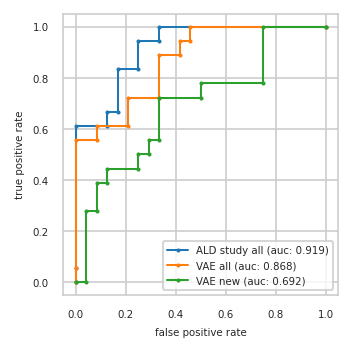

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       VAE all       VAE new      
             fpr   tpr     fpr   tpr     fpr   tpr
0          0.000 0.000   0.000 0.000   0.000 0.000
1          0.000 0.056   0.000 0.056   0.042 0.000
2          0.000 0.611   0.000 0.556   0.042 0.278
3          0.125 0.611   0.083 0.556   0.083 0.278
4          0.125 0.667   0.083 0.611   0.083 0.389
5          0.167 0.667   0.208 0.611   0.125 0.389
6          0.167 0.833   0.208 0.722   0.125 0.444
7          0.250 0.833   0.333 0.722   0.250 0.444
8          0.250 0.944   0.333 0.889   0.250 0.500
9          0.333 0.944   0.417 0.889   0.292 0.500
10         0.333 1.000   0.417 0.944   0.292 0.556
11         1.000 1.000   0.458 0.944   0.333 0.556
12           NaN   NaN   0.458 1.000   0.333 0.722
13           NaN   NaN   1.000 1.000   0.500 0.722
14           NaN   NaN     NaN   NaN   0.500 0.778
15           NaN   NaN     NaN   NaN   0.750 0.778
16           NaN   NaN     NaN   NaN   0.750 1.000
17           NaN   NaN     NaN   NaN   1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,VAE all,VAE new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,Q9NZ53,P22676,P42262;P42262-2;P42262-3
2,Q8IWT1,Q0P6D2,P51688
3,P04075,Q14894,P30048;P30048-2
4,P14174,P63104,A0A0C4DGV4;E9PLX3;O43504;R4GMU8
5,P08253,Q9Y2T3;Q9Y2T3-3,P31321
6,None,P04075,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
7,None,P61981,J3KSJ8;Q9UD71;Q9UD71-2
8,None,C9JF17;P05090,A0A075B7B8


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf


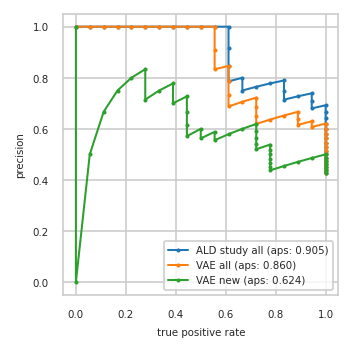

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all         VAE all         VAE new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.500 1.000     0.500 1.000     0.500 1.000
7          0.514 1.000     0.514 1.000     0.486 0.944
8          0.529 1.000     0.529 1.000     0.471 0.889
9          0.545 1.000     0.545 1.000     0.455 0.833
10         0.562 1.000     0.562 1.000     0.438 0.778
11         0.581 1.000     0.581 1.000     0.452 0.778
12         0.600 1.000     0.600 1.000     0.467 0.778
13         0.621 1.000     0.621 1.000     0.483 0.778
14         0.643 1.000     0.607 0.944     0.500 0.778
15         0.667 1.000     0.630 0.944     0.519 0.778
16         0.692 1.000     0.615 0.889     0.538 0.778
17         0.680 0.944     0.640 0.889     0.520 0.722
18         0.708 0.944     0.667 0.889     0.542 0.722
19         0.739 0.944     0.652 0.833     0.565 0.722
20         0.727 0.889     0.636 0.778     0.591 0.722
21         0.714 0.833     0.619 0.722     0.619 0.722
22         0.750 0.833     0.650 0.722     0.600 0.667
23         0.789 0.833     0.684 0.722     0.579 0.611
24         0.778 0.778     0.722 0.722     0.556 0.556
25         0.765 0.722     0.706 0.667     0.588 0.556
26         0.750 0.667     0.688 0.611     0.562 0.500
27         0.800 0.667     0.733 0.611     0.600 0.500
28         0.786 0.611     0.786 0.611     0.571 0.444
29         0.846 0.611     0.846 0.611     0.615 0.444
30         0.917 0.611     0.833 0.556     0.667 0.444
31         1.000 0.611     0.909 0.556     0.727 0.444
32         1.000 0.556     1.000 0.556     0.700 0.389
33         1.000 0.500     1.000 0.500     0.778 0.389
34         1.000 0.444     1.000 0.444     0.750 0.333
35         1.000 0.389     1.000 0.389     0.714 0.278
36         1.000 0.333     1.000 0.333     0.833 0.278
37         1.000 0.278     1.000 0.278     0.800 0.222
38         1.000 0.222     1.000 0.222     0.750 0.167
39         1.000 0.167     1.000 0.167     0.667 0.111
40         1.000 0.111     1.000 0.111     0.500 0.056
41         1.000 0.056     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf


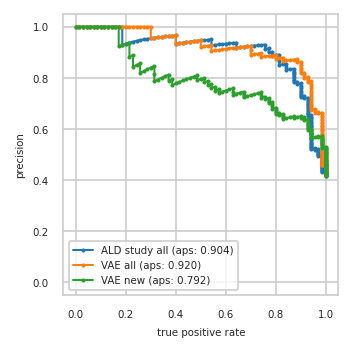

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf


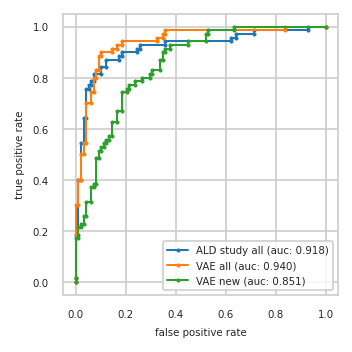

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_VAE all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE all.pkl'),
 'results_VAE new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf')}